<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
<font color=#4d7db8>
Sharif University of Technology - Department of Electrical Engineering
</font>
<p></p>
<font color=#4d7db8>
Introduction To Machine Learning - Dr. Sajjad Amini
</font>
<br/>
<br/>
Spring Semester 1401-02

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Project - 3rd Phase
<br />
Image Denoising using Autoencoder and PCA
			</font>
    <br/>
<font size=4>
			<br/><br/>
Due on Tir 10th
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=green>
Should you have any questions concerning the project, please feel free to ask via Telegram.
     </font>
</font>
                <br/>
    </div>

# Personal Info
<hr/>
    <div class="column" align=center>
    <font size=4>
        <div class="column">
        <br />
            student_number = 400102222
            <br />
            Name = Amirreza 
            <br />
            Last_Name = Velae 
        </div>
        <div class="column">
        <br />
            student_number =99101416
            <br />
            Name = Mohammadreza   
            <br />
            Last_Name = Haji Babaei
        </div>
    </font>
    </div>


1. Download the MNIST dataset and create a dataloader that adds gaussian noise to the input images.
2. Design and train an AutoEncoder on the MNIST dataset to denoise the noisy images.
3. Visualize original images, their corresponding noisy images and their reconstructed versions side by side.
4. Repeat the previous steps using PCA algorithm.

# Import Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import tensorflow as tf
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd
import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import copy


# Load Dataset and Prepare It

In [22]:
# Source :https://plainenglish.io/blog/denoising-autoencoder-in-pytorch-on-mnist-dataset-a76b8824e57e
# With some modifications and edits




data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

def add_noise(inputs,noise_factor=0.3):
	noisy = inputs+torch.randn_like(inputs) * noise_factor
	noisy = torch.clip(noisy,0.,1.)
	return noisy


In [8]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

# Define Your Model
torch neural network model

In [9]:
class Encoder(nn.Module):

	def __init__(self, encoded_space_dim,fc2_input_dim):
		super().__init__()

		### Convolutional section
		self.encoder_cnn = nn.Sequential(
		nn.Conv2d(1, 8, 3, stride=2, padding=1),
		nn.ReLU(True),
		nn.Conv2d(8, 16, 3, stride=2, padding=1),
		nn.BatchNorm2d(16),
		nn.ReLU(True),
		nn.Conv2d(16, 32, 3, stride=2, padding=0),
		nn.ReLU(True)
		)

		### Flatten layer
		self.flatten = nn.Flatten(start_dim=1)
### Linear section
		self.encoder_lin = nn.Sequential(
			nn.Linear(3 * 3 * 32, 128),
			nn.ReLU(True),
			nn.Linear(128, encoded_space_dim)
		)

	def forward(self, x):
		x = self.encoder_cnn(x)
		x = self.flatten(x)
		x = self.encoder_lin(x)
		return x
class Decoder(nn.Module):

	def __init__(self, encoded_space_dim,fc2_input_dim):
		super().__init__()
		self.decoder_lin = nn.Sequential(
			nn.Linear(encoded_space_dim, 128),
			nn.ReLU(True),
			nn.Linear(128, 3 * 3 * 32),
			nn.ReLU(True)
		)

		self.unflatten = nn.Unflatten(dim=1,
		unflattened_size=(32, 3, 3))

		self.decoder_conv = nn.Sequential(
			nn.ConvTranspose2d(32, 16, 3,
			stride=2, output_padding=0),
			nn.BatchNorm2d(16),
			nn.ReLU(True),
			nn.ConvTranspose2d(16, 8, 3, stride=2,
			padding=1, output_padding=1),
			nn.BatchNorm2d(8),
			nn.ReLU(True),
			nn.ConvTranspose2d(8, 1, 3, stride=2,
			padding=1, output_padding=1)
		)

	def forward(self, x):
		x = self.decoder_lin(x)
		x = self.unflatten(x)
		x = self.decoder_conv(x)
		x = torch.sigmoid(x)
		return x
	
    ### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
	{'params': encoder.parameters()},
	{'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

# Fit The Model
Also Define optimizer, Criterion and other parameters 

In [10]:
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
	# Set train mode for both the encoder and the decoder
	encoder.train()
	decoder.train()
	train_loss = []
	# Iterate the dataloader (we do not need the label values, this is unsupervised learning)
	for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
		# Move tensor to the proper device
		image_noisy = add_noise(image_batch,noise_factor)
		image_batch = image_batch.to(device)
		image_noisy = image_noisy.to(device)
		# Encode data
		encoded_data = encoder(image_noisy)
		# Decode data
		decoded_data = decoder(encoded_data)
		# Evaluate loss
		loss = loss_fn(decoded_data, image_batch)
		# Backward pass
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		# Print batch loss
		print('\t partial train loss (single batch): %f' % (loss.data), end="\r")
		train_loss.append(loss.detach().cpu().numpy())

	return np.mean(train_loss)
### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
	# Set evaluation mode for encoder and decoder
	encoder.eval()
	decoder.eval()
	with torch.no_grad(): # No need to track the gradients
		# Define the lists to store the outputs for each batch
		conc_out = []
		conc_label = []
		for image_batch, _ in dataloader:
			# Move tensor to the proper device
			image_noisy = add_noise(image_batch,noise_factor)
			image_noisy = image_noisy.to(device)
			# Encode data
			encoded_data = encoder(image_noisy)
			# Decode data
			decoded_data = decoder(encoded_data)
			# Append the network output and the original image to the lists
			conc_out.append(decoded_data.cpu())
			conc_label.append(image_batch.cpu())
		# Create a single tensor with all the values in the lists
		conc_out = torch.cat(conc_out)
		conc_label = torch.cat(conc_label)
		# Evaluate global loss
		val_loss = loss_fn(conc_out, conc_label)
	return val_loss.data



# Train the model
noise_factor = 0.3
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}

best_encoder = copy.deepcopy(encoder)
best_decoder = copy.deepcopy(decoder)
best_val_loss = np.inf

for epoch in range(num_epochs):
	print('EPOCH %d/%d' % (epoch + 1, num_epochs))
	### Training (use the training function)
	train_loss=train_epoch_den(
		encoder=encoder,
		decoder=decoder,
		device=device,
		dataloader=train_loader,
		loss_fn=loss_fn,
		optimizer=optim,noise_factor=noise_factor)
	### Validation (use the testing function)
	val_loss = test_epoch_den(
		encoder=encoder,
		decoder=decoder,
		device=device,
		dataloader=valid_loader,
		loss_fn=loss_fn,noise_factor=noise_factor)
	# Print Validationloss
	history_da['train_loss'].append(train_loss)
	history_da['val_loss'].append(val_loss)
	print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
	# Save best model, if current model is better than previous best, both encoder and decoder are saved
	if val_loss < best_val_loss:
		best_val_loss = val_loss
		best_encoder = copy.deepcopy(encoder)
		best_decoder = copy.deepcopy(decoder)
		print('\t Best model found!')
# Plot some reconstructed images

EPOCH 1/30
	 partial train loss (single batch): 0.065532
 EPOCH 1/30 	 train loss 0.123 	 val loss 0.065
	 Best model found!
EPOCH 2/30
	 partial train loss (single batch): 0.045372
 EPOCH 2/30 	 train loss 0.054 	 val loss 0.047
	 Best model found!
EPOCH 3/30
	 partial train loss (single batch): 0.036087
 EPOCH 3/30 	 train loss 0.043 	 val loss 0.039
	 Best model found!
EPOCH 4/30
	 partial train loss (single batch): 0.031395
 EPOCH 4/30 	 train loss 0.036 	 val loss 0.034
	 Best model found!
EPOCH 5/30
	 partial train loss (single batch): 0.029450
 EPOCH 5/30 	 train loss 0.033 	 val loss 0.033
	 Best model found!
EPOCH 6/30
	 partial train loss (single batch): 0.028509
 EPOCH 6/30 	 train loss 0.031 	 val loss 0.031
	 Best model found!
EPOCH 7/30
	 partial train loss (single batch): 0.027660
 EPOCH 7/30 	 train loss 0.031 	 val loss 0.031
	 Best model found!
EPOCH 8/30
	 partial train loss (single batch): 0.026964
 EPOCH 8/30 	 train loss 0.030 	 val loss 0.030
	 Best model found!


# Plot The Results

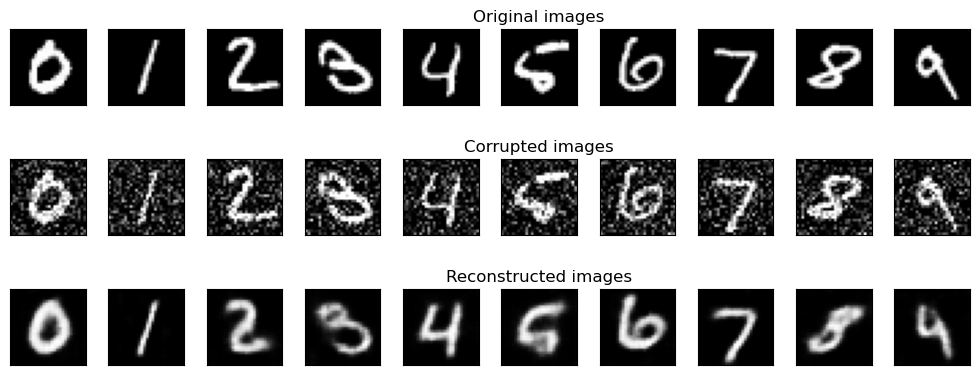

In [11]:
def plot_ae_outputs_den(encoder,decoder,n=10,noise_factor=0.3):
	plt.figure(figsize=(16,4.5))
	targets = test_dataset.targets.numpy()
	t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
	for i in range(n):

		ax = plt.subplot(3,n,i+1)
		img = test_dataset[t_idx[i]][0].unsqueeze(0)
		image_noisy = add_noise(img,noise_factor)
		image_noisy = image_noisy.to(device)

		encoder.eval()
		decoder.eval()

		with torch.no_grad():
			rec_img = decoder(encoder(image_noisy))

		plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)
		if i == n//2:
			ax.set_title('Original images')
		ax = plt.subplot(3, n, i + 1 + n)
		plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)
		if i == n//2:
			ax.set_title('Corrupted images')

		ax = plt.subplot(3, n, i + 1 + n + n)
		plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)
		if i == n//2:
			ax.set_title('Reconstructed images')
	plt.subplots_adjust(left=0.1,
					bottom=0.1,
					right=0.7,
					top=0.9,
					wspace=0.3,
					hspace=0.3)
	plt.show()
	
plot_ae_outputs_den(best_encoder,best_decoder,noise_factor=noise_factor)


# PCA

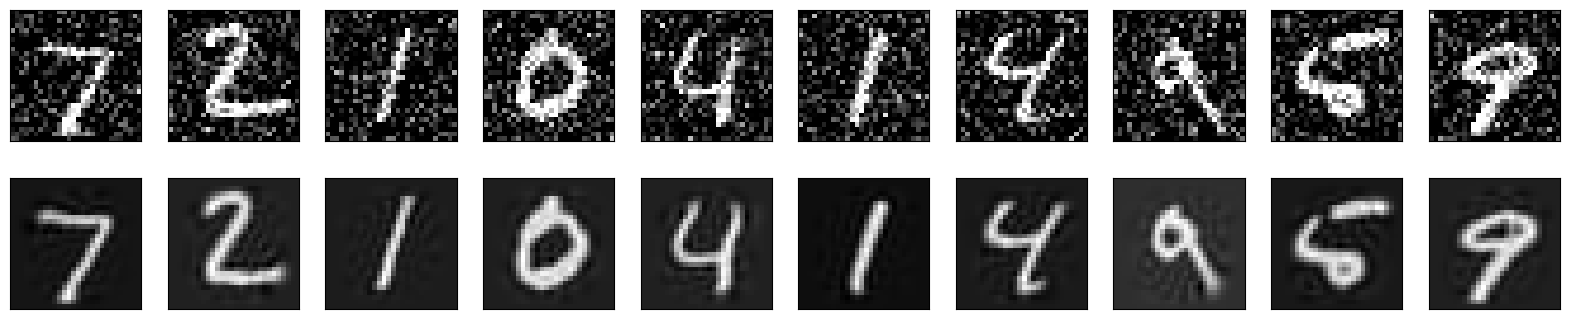

In [21]:
# Deniose the images via PCA
from sklearn.decomposition import PCA

train_data = train_dataset.data.numpy()
test_data = test_dataset.data.numpy()

pca = PCA(n_components=0.95)
train_X_pca = pca.fit_transform(train_data.reshape(-1, 28 * 28))
test_X_pca = pca.transform(test_data.reshape(-1, 28 * 28))

# Plot the denoised images
plt.figure(figsize=(20, 4))

for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    img = test_dataset[i][0].unsqueeze(0)

    image_noisy = add_noise(img,noise_factor)
    image_noisy = image_noisy.to(device)
    plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i+11)
    plt.imshow(pca.inverse_transform(test_X_pca[i]).reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
